# Compute  PCA : Method 1 : Clustering

- use PCA scikit learn from scikit learn

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/12/28
- update : 2022/12/28

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from mpl_toolkits.mplot3d import axes3d  

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

from astroML.utils.decorators import pickle_results


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [3]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [4]:
from astropy.io import fits
import copy

In [5]:
filename = "pcamethod1_SL_eigenvectorandcoeff.fits"
hdu = fits.open(filename)

In [6]:
hdu.info()

Filename: pcamethod1_SL_eigenvectorandcoeff.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   (6362, 553)   float64   
  1                1 ImageHDU         8   (10, 550)   float64   
  2                1 ImageHDU         8   (6361, 10)   float64   


In [7]:
data1=hdu[0].data
hdr1 = hdu[0].header
hdr1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6362                                                  
NAXIS2  =                  553                                                  
EXTEND  =                    T                                                  
DATAWLS = 'data[0,1:]'                                                          
DATALLAV= 'data[1,1:]'                                                          
DATALLST= 'data[2,1:]'                                                          
DATAFL  = 'data[3:,1:]'                                                         
DATANUM = 'data[3:,0]'                                                          
COMMENT Spectra of StarLight                                                    

In [8]:
data2=hdu[1].data
hdr2 = hdu[1].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   10                                                  
NAXIS2  =                  550                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 spectra coefficients                                       

In [9]:
data3=hdu[2].data
hdr2 = hdu[2].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6361                                                  
NAXIS2  =                   10                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 Eigen Vectors                                              

In [10]:
NSED = data1.shape[0]-3
NWL = data1.shape[1]-1

In [11]:
wavelengths = data1[0,1:] 
flambdas_average = data1[1,1:] 
flambdas_std = data1[2,1:] 
spec = data1[3:,1:] 
all_numbers = data1[3:,0] 

In [12]:
#flux = dfluxnorm*flambdas_std +  flambdas_average

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_25180/1659706449.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Flux average')

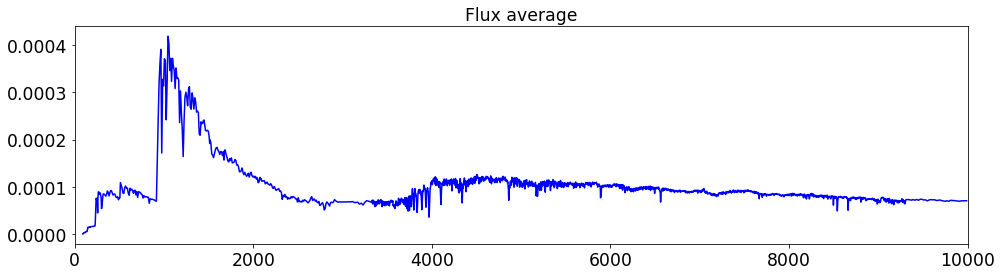

In [13]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths,flambdas_average,'b-')
plt.xlim(0.,10000.)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title("Flux average")

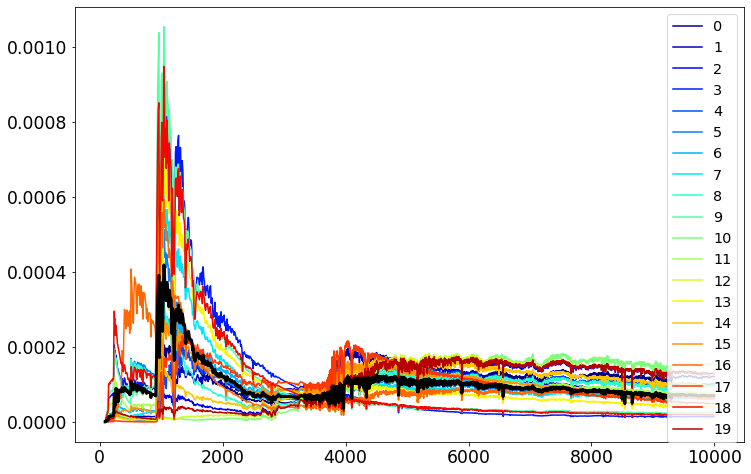

In [14]:
# wavelength bin colors
NTOPLOT=20
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)


fig = plt.figure(figsize=(12, 8))

for idx in np.arange(20):
    plt.plot(wavelengths,spec[idx,:],color=all_colors[idx],label=str(idx))

plt.legend()
spec_mean = spec.mean(0)
plt.plot(wavelengths,spec_mean,"k-",lw=3)
#plt.ylim(0,50.)

# Clustering

## Clustering from PCA coefficients

In [15]:
X = copy.deepcopy(data2)

In [16]:
X.shape

(550, 10)

In [32]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix


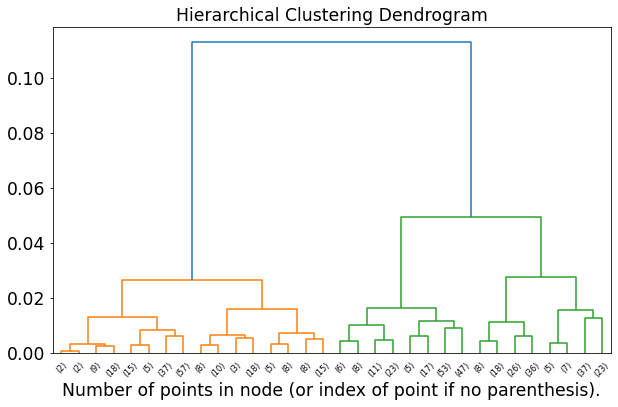

In [33]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
matrix = plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


In [34]:
matrix.shape

(549, 4)

In [35]:
matrix

array([[1.56000000e+02, 3.42000000e+02, 1.00195222e-14, 2.00000000e+00],
       [3.64000000e+02, 3.75000000e+02, 1.05203425e-14, 2.00000000e+00],
       [9.70000000e+01, 5.50000000e+02, 1.37886971e-14, 3.00000000e+00],
       ...,
       [1.08800000e+03, 1.09200000e+03, 2.74705145e-02, 1.60000000e+02],
       [1.09400000e+03, 1.09600000e+03, 4.92952024e-02, 3.30000000e+02],
       [1.09500000e+03, 1.09700000e+03, 1.12880312e-01, 5.50000000e+02]])

In [25]:
model.n_leaves_

550

In [31]:
model.children_.shape

(549, 2)

In [36]:
model.distances_

array([1.00195222e-14, 1.05203425e-14, 1.37886971e-14, 1.67709621e-10,
       1.17131573e-05, 2.30698693e-05, 2.88134652e-05, 3.42441722e-05,
       3.58065106e-05, 3.76364760e-05, 5.47475368e-05, 5.89109854e-05,
       6.43060312e-05, 7.94950856e-05, 8.09806761e-05, 8.49178739e-05,
       9.03650136e-05, 9.23084190e-05, 9.36054458e-05, 9.44235247e-05,
       9.51681145e-05, 9.64444514e-05, 9.67716026e-05, 9.88172950e-05,
       9.98674167e-05, 1.03726081e-04, 1.05157626e-04, 1.05560401e-04,
       1.07364685e-04, 1.11521437e-04, 1.12061872e-04, 1.12764290e-04,
       1.19418286e-04, 1.19689973e-04, 1.19940591e-04, 1.20343274e-04,
       1.24867589e-04, 1.25628305e-04, 1.28242647e-04, 1.44499073e-04,
       1.46437041e-04, 1.51508360e-04, 1.51891252e-04, 1.51950400e-04,
       1.53264164e-04, 1.54310230e-04, 1.56361784e-04, 1.56415057e-04,
       1.58158180e-04, 1.58608744e-04, 1.62898978e-04, 1.64677880e-04,
       1.67986201e-04, 1.69779909e-04, 1.77241450e-04, 1.80690504e-04,
      

### Clustering from Spectra

In [19]:
X = copy.deepcopy(spec)

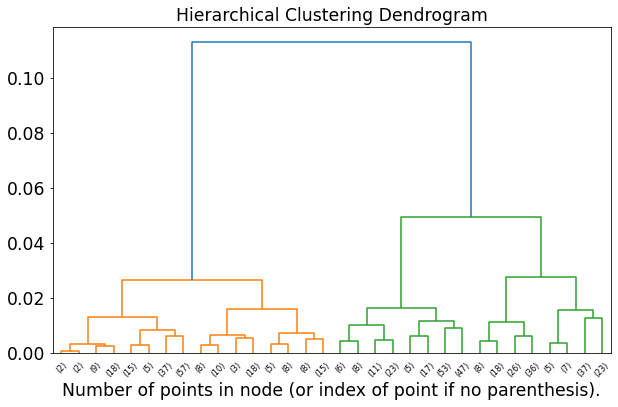

In [20]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()